In [21]:
import numpy as np
import pandas as pd

# Customer Data - Simulating data from a CRM system, this is 5000 sample of customers WW
- Customer ID: Unique ID given to customer in CRM

- Customer Size: Number of active full time employees that we use for licensing

- Annual Revenue: The latest reported revenue the customer reported based on sales intelligence softwate in the CRM 

- Industry: Customer industry

- C-Level Engagment: In B2B sales, how engaged we are to high level executives to get buy in for renewing contracts is critical, this is measuring how engaged they are from 'low' < 'medium' < 'high' based on email and meeting activity on the CRM

- Open Deals: Number of open opportunities tied to the customer account in the CRM

- Customer Sign Up Date: The day the customer officualy signed their contract

- Amount ARR Cloud: Annual Reoccuring Revenue coming from the customer payment for our SaaS service 

- Amount ARR On Prem: Annual Reoccuring Revenue coming from the customer payment for our on premises services

- Feature 1 Usage: From a scale 'low' < 'medium' < 'high' - how much the customer is leveraging Feature 1

- Feature 2 Usage: From a scale 'low' < 'medium' < 'high' - how much the customer is leveraging Feature 2

- Feature 3 Usage: From a scale 'low' < 'medium' < 'high' - how much the customer is leveraging Feature 3

- Churned: '0' indicates the customer is still active, '1' did not renew their contract

In [22]:
number_samples = 6000

# Lists to generate categorical features
industry = ['Automotive', 'Finance', 'Healthcare', 'Retail', 'Technology', 'Government', 'Education', 'Manufacturing', 'Food and Beverage', 'Energy']
weighted_industry = np.random.rand(10)
weighted_industry = weighted_industry / weighted_industry.sum()
feature_use = ['low', 'medium', 'high']

# Helper function to generate random business dates
def random_dates(start, end, n):
    business_days = pd.date_range(start=start, end=end, freq='B')
    return np.random.choice(business_days, size=n, replace=True)

# Example usage
random_dates(pd.to_datetime('2015-01-01'), pd.to_datetime('2023-01-01'), 5)  # Example usage


array(['2020-03-26T00:00:00.000000000', '2019-02-19T00:00:00.000000000',
       '2021-11-09T00:00:00.000000000', '2017-05-15T00:00:00.000000000',
       '2020-01-02T00:00:00.000000000'], dtype='datetime64[ns]')

In [23]:
customer_data = {
    'customer_id': np.arange(1, number_samples + 1),
    'customer_size': np.random.normal(1500, 250, number_samples).astype(int),
    'annual_revenue': np.random.normal(1000000, 200000, number_samples).round(2),
    'industry': np.random.choice(industry, number_samples, p=weighted_industry),
    'c_level_engagement': np.random.choice(feature_use, number_samples, p=[0.2, 0.7, 0.1]),
    'open_deals': np.random.binomial(1, 0.2, number_samples),
    'customer_sign_up_date': random_dates(pd.to_datetime('2010-01-01'), pd.to_datetime('2022-12-31'), number_samples),
    'amount_ARR_cloud': np.random.lognormal(12, 0.52, number_samples).round(2),
    'amount_ARR_on_prem': np.random.lognormal(9, 0.3, number_samples).round(2),
    'feature_1_usage': np.random.choice(feature_use, number_samples, p=[0.1, 0.3, 0.6]),
    'feature_2_usage': np.random.choice(feature_use, number_samples, p=[0.1, 0.1, 0.8]),
    'feature_3_usage': np.random.choice(feature_use, number_samples, p=[0.3, 0.1, 0.6]),
}


# Additional Features to Contruct
- Next Renewal Data: The date the contract expires

- Last QBR Date: The last date the account team held a Quaterly Business Review witht the customer executives

- Amount ARR Total: Sum of ARR Cloud and ARR On premises, total customer spend

- Customer Age: Number of Months the account has been an active customer

- Days between Renewal and QBR: Number of days between the last QBR date and the date the contract expires 

In [24]:
# Translate the customer data into a DataFrame and create additional features
df_customers = pd.DataFrame(customer_data)
df_customers['next_renewal_date'] = df_customers['customer_sign_up_date'] + pd.DateOffset(years=3)
df_customers['last_qbr_date'] = df_customers.apply(lambda df: random_dates(df['customer_sign_up_date'], 
                                                            df['next_renewal_date'], 1)[0], 
                                                            axis=1)
df_customers['amount_ARR_total'] = df_customers['amount_ARR_cloud'] + df_customers['amount_ARR_on_prem']
df_customers['customer_age'] = (pd.Timestamp.now() - df_customers['customer_sign_up_date']).dt.days // 30
df_customers['days_between_renewal_and_qbr'] = (df_customers['next_renewal_date'] - df_customers['last_qbr_date']).dt.days
list(df_customers.columns)


['customer_id',
 'customer_size',
 'annual_revenue',
 'industry',
 'c_level_engagement',
 'open_deals',
 'customer_sign_up_date',
 'amount_ARR_cloud',
 'amount_ARR_on_prem',
 'feature_1_usage',
 'feature_2_usage',
 'feature_3_usage',
 'next_renewal_date',
 'last_qbr_date',
 'amount_ARR_total',
 'customer_age',
 'days_between_renewal_and_qbr']

In [25]:
arr_cloud_threshold = df_customers['amount_ARR_cloud'].quantile(0.10)
arr_on_prem_threshold = df_customers['amount_ARR_on_prem'].quantile(0.10)
age_threshold = df_customers['customer_age'].quantile(0.10)
size_threshold = df_customers['customer_size'].quantile(0.20)
rev_threshold = df_customers['annual_revenue'].quantile(0.10)

# Assuming all quantile thresholds (arr_cloud_threshold, etc.) are defined correctly above.

# Assuming all quantile thresholds (arr_cloud_threshold, etc.) are defined correctly above.

def calculate_churn_prob(row):

    # Stronger base rate for separation
    churn_prob = 0.01  


    # -------------------------------------------------------
    # 1. Strongest Predictors (HEAVY WEIGHTS)
    # -------------------------------------------------------

    # Low ARR → heavily correlated with churn for you (-0.12 to -0.11)
    if row['amount_ARR_total'] < df_customers['amount_ARR_total'].median():
        churn_prob += 0.25

    # Low ARR Cloud
    if row['amount_ARR_cloud'] < df_customers['amount_ARR_cloud'].median():
        churn_prob += 0.15

    # Low ARR On-Prem
    if row['amount_ARR_on_prem'] < df_customers['amount_ARR_on_prem'].median():
        churn_prob += 0.10


    # No open deals (moderate negative correlation)
    if row['open_deals'] == 0:
        churn_prob += 0.12


    # -------------------------------------------------------
    # 2. Engagement-Driven Predictors (STRONG SIGNALS)
    # -------------------------------------------------------

    # Usage
    if row['feature_1_usage'] == 'low':
        churn_prob += 0.12
    elif row['feature_1_usage'] == 'high':
        churn_prob -= 0.05

    if row['feature_2_usage'] == 'low':
        churn_prob += 0.12
    elif row['feature_2_usage'] == 'high':
        churn_prob -= 0.05

    # C-level engagement
    if row['c_level_engagement'] == 'low':
        churn_prob += 0.20
    elif row['c_level_engagement'] == 'high':
        churn_prob -= 0.10


    # -------------------------------------------------------
    # 3. Logistic Risk Factors (WEAKER BUT STILL POSITIVE)
    # -------------------------------------------------------

    if row['days_between_renewal_and_qbr'] > 180:
        churn_prob += 0.10

    if row['industry'] in ['Manufacturing', 'Healthcare', 'Automotive']:
        churn_prob += 0.05


    # -------------------------------------------------------
    # 4. Retention-Driving Predictors (NEGATIVE WEIGHTS)
    # -------------------------------------------------------

    # High ARR deters churn (but lighter penalty so high-ARR churn still possible)
    if row['amount_ARR_total'] > df_customers['amount_ARR_total'].quantile(0.8):
        churn_prob -= 0.15

    # Super-engaged users
    if row['feature_1_usage'] == 'high' and row['feature_2_usage'] == 'high':
        churn_prob -= 0.10


    return np.clip(churn_prob, 0, 1)


In [26]:
df_customers['churn_probability'] = df_customers.apply(calculate_churn_prob, axis=1)

In [27]:
#Use the new probability column to generate the 'churned' flag
df_customers['churned'] = [np.random.binomial(1, p) for p in df_customers['churn_probability']]

# (Optional: Drop the intermediate 'churn_probability' column)
#df_customers = df_customers.drop(columns=['churn_probability'])
df_customers.head()

,customer_id,customer_size,annual_revenue,industry,c_level_engagement,open_deals,customer_sign_up_date,amount_ARR_cloud,amount_ARR_on_prem,feature_1_usage,feature_2_usage,feature_3_usage,next_renewal_date,last_qbr_date,amount_ARR_total,customer_age,days_between_renewal_and_qbr,churn_probability,churned
0,1,1475,804596.82,Finance,medium,1,2014-03-07,119194.17,8167.70,medium,high,low,2017-03-07,2015-07-08,127361.87,142,608,0.46,0
1,2,1552,871342.57,Healthcare,medium,0,2020-09-07,91621.09,10043.98,medium,high,high,2023-09-07,2023-04-24,101665.07,63,136,0.53,0
2,3,1773,1043744.66,Retail,medium,0,2016-08-26,278745.96,5539.81,high,high,high,2019-08-26,2017-05-15,284285.77,112,833,0.00,0
3,4,1518,992437.78,Healthcare,medium,1,2020-09-04,195754.58,7356.65,high,high,high,2023-09-04,2020-11-11,203111.23,63,1027,0.06,0
4,5,1931,1238123.57,Healthcare,high,0,2015-05-28,188470.47,6479.03,low,high,high,2018-05-28,2018-02-14,194949.50,128,103,0.25,0


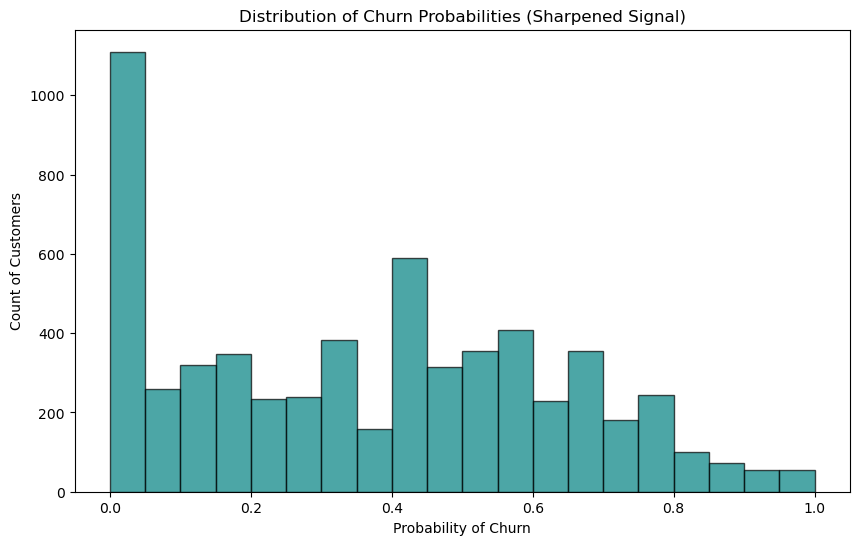

amount_ARR_total               -0.356854
amount_ARR_cloud               -0.355257
open_deals                     -0.077560
amount_ARR_on_prem             -0.068819
customer_size                  -0.022931
customer_age                   -0.012943
customer_id                    -0.000050
annual_revenue                  0.017330
days_between_renewal_and_qbr    0.037284
churn_probability               0.562294
churned                         1.000000
Name: churned, dtype: float64


In [28]:
# Check the distribution - You want to see a spread, not just a lump in the middle!
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(df_customers['churn_probability'], bins=20, color='teal', edgecolor='black', alpha=0.7)
plt.title('Distribution of Churn Probabilities (Sharpened Signal)')
plt.xlabel('Probability of Churn')
plt.ylabel('Count of Customers')
plt.show()

# Quick check on correlation
print(df_customers.select_dtypes(include=[np.number]).corr()['churned'].sort_values())

In [29]:
# Reviewing date features
df_customers[['customer_sign_up_date','next_renewal_date','last_qbr_date','days_between_renewal_and_qbr']].head()

,customer_sign_up_date,next_renewal_date,last_qbr_date,days_between_renewal_and_qbr
0,2014-03-07,2017-03-07,2015-07-08,608
1,2020-09-07,2023-09-07,2023-04-24,136
2,2016-08-26,2019-08-26,2017-05-15,833
3,2020-09-04,2023-09-04,2020-11-11,1027
4,2015-05-28,2018-05-28,2018-02-14,103


In [30]:
df_customers.drop(columns=['churn_probability'], inplace=True)
df_customers.to_csv('exported_customer_data.csv', index=False)